# CESM2-LE Micro predictability analysis
 - examines initialization signal in density-space MOC

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import util
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [11]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(20) 

In [3]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
cluster

### Data I/O functions:

In [4]:
def micro_nested_file_list_by_member(datadir,ens,microlabel):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)+1
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        #build casename
        mmm = str(ee).zfill(3)
        casename = 'b.e21.BHISTcmip6.f09_g17.'+microlabel+'.'+mmm
        if (ee>10):  casename = 'b.e21.BHISTsmbb.f09_g17.'+microlabel+'.'+mmm
        casedir = datadir+casename+'/'
        #find all the relevant files
        mocfiles = sorted(glob.glob(casedir+'*.MOCsig.*.nc'))
        ffs = mocfiles[0:11]
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [5]:
def macro1a_nested_file_list_by_member(datadir,ens):
    members = []
    for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
        s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
        members.append(s)
    
    ens = np.array(ens)+1
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        #build casename
        casename = 'b.e21.BHISTcmip6.f09_g17.'+members[i]
        casedir = datadir+casename+'/'
        #find all the relevant files
        mocfiles = sorted(glob.glob(casedir+'*.MOCsig.*.nc'))
        ffs = mocfiles[0:11]
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [6]:
def macro1b_nested_file_list_by_member(datadir,ens):
    members = []
    for i,j in zip(1011+20*np.arange(10),1+np.arange(10)):
        s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
        members.append(s)
    
    ens = np.array(ens)+1
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        #build casename
        casename = 'b.e21.BHISTsmbb.f09_g17.'+members[i]
        casedir = datadir+casename+'/'
        #find all the relevant files
        mocfiles = sorted(glob.glob(casedir+'*.MOCsig.*.nc'))
        ffs = mocfiles[0:11]
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [7]:
def macro2_nested_file_list_by_member(datadir,ens):    
    ens = np.array(ens)+1
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        #build casename
        mmm = str(ee).zfill(3)
        casename = 'b.e21.BHIST.f09_g17.CMIP6-historical.'+mmm
        casedir = datadir+casename+'/'
        #find all the relevant files
        mocfiles = sorted(glob.glob(casedir+'*.MOCsig.*.nc'))
        ffs = mocfiles[0:11]
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [8]:
def open_single_member(files):
    
    d0 = xr.open_mfdataset(files,combine='by_coords',parallel=True,concat_dim='time',chunks={},compat='override', coords='minimal')
    # quick fix to adjust time vector for monthly data  
    nmonths = len(d0.time)
    yr0 = d0['time.year'][0].values
    d0['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    
    return d0

In [9]:
def get_data(files):
    ''' returns dask array containing the requested hindcast ensemble '''

    ens = np.array(range(np.shape(files)[0]))+1
    dsets = []
    in_obj = [[ffs] for ffs in files]
    dsets = client.map(open_single_member, in_obj)
    dsets = client.gather(dsets)
    ds = xr.concat(dsets,dim='M',coords='minimal', compat='override')
    ds = ds.assign_coords(M=("M",ens))

    return ds

## Read in Micro and Macro Ensembles
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 20-member "macro1" (new macro) ensemble (macro1a + macro1b)
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}
  - 30-member macro ensemble (macro1 + macro2)
  - 100-member "all" ensemble (micro1 + micro2 + micro3 + micro4 + macro1)

In [10]:
%%time
# Micro 1231
files1231,mems1231 = micro_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(20),'LE2-1231')
ds1231 = get_data(files1231)

ValueError: must supply at least one object to concatenate

In [51]:
%%time
# Micro 1251
files1251,mems1251 = micro_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(20),'LE2-1251')
ds1251 = get_data(files1251)

CPU times: user 517 ms, sys: 35.6 ms, total: 552 ms
Wall time: 1.03 s


In [52]:
%%time
# Micro 1281
files1281,mems1281 = micro_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(20),'LE2-1281')
ds1281 = get_data(files1281)

CPU times: user 517 ms, sys: 25.6 ms, total: 543 ms
Wall time: 1.06 s


In [53]:
%%time
# Micro 1301
files1301,mems1301 = micro_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(20),'LE2-1301')
ds1301 = get_data(files1301)

CPU times: user 527 ms, sys: 31.3 ms, total: 558 ms
Wall time: 999 ms


In [54]:
%%time
# Macro 1a (10 member, normal)
filesm1a,memsm1a = macro1a_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(10))
dsmacro1a = get_data(filesm1a).persist()

CPU times: user 289 ms, sys: 20 ms, total: 309 ms
Wall time: 697 ms


In [55]:
%%time
# Macro 1b (10 member, MOAR)
filesm1b,memsm1a = macro1b_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(10))
dsmacro1b = get_data(filesm1b).persist()

CPU times: user 752 ms, sys: 47 ms, total: 799 ms
Wall time: 2.29 s


In [56]:
%%time
# Macro 2 (10 member from CMIP6)
filesm2,memsm2 = macro2_nested_file_list_by_member('/glade/scratch/yeager/cesm2_le/',range(10))
dsmacro2 = get_data(filesm2).persist()

CPU times: user 794 ms, sys: 40.9 ms, total: 835 ms
Wall time: 2.29 s


In [57]:
%%time
# Construct 20-member macro1 ensemble
dsmacro1b = dsmacro1b.assign_coords(M=("M",np.array(range(10))+11))
dsmacro1 = xr.concat([dsmacro1a,dsmacro1b],dim='M',coords='minimal', compat='override')

# Construct 30-member "macro1+macro2" ensemble
dsmacro2 = dsmacro2.assign_coords(M=("M",np.array(range(10))+21))
dsmacro = xr.concat([dsmacro1,dsmacro2],dim='M',coords='minimal', compat='override')

# Construct full 100-member grand ensemble
tmp1 = ds1231.copy()
tmp1 = tmp1.assign_coords(M=("M",np.array(range(20))+21))
tmp2 = ds1251.copy()
tmp2 = tmp2.assign_coords(M=("M",np.array(range(20))+41))
tmp3 = ds1281.copy()
tmp3 = tmp3.assign_coords(M=("M",np.array(range(20))+61))
tmp4 = ds1301.copy()
tmp4 = tmp4.assign_coords(M=("M",np.array(range(20))+81))
dsall = dsmacro2.assign_coords(M=("M",np.array(range(10))+21))
dsall = xr.concat([dsmacro1,tmp1,tmp2,tmp3,tmp4],dim='M',coords='minimal', compat='override')

CPU times: user 25.9 ms, sys: 0 ns, total: 25.9 ms
Wall time: 25.9 ms


In [58]:
dsall

<xarray.Dataset>
Dimensions:            (M: 100, lat_aux_grid: 395, moc_comp: 3, moc_s: 87, time: 1320, transport_reg: 2)
Coordinates:
  * time               (time) object 1850-01-01 00:00:00 ... 1959-12-01 00:00:00
    transport_regions  (transport_reg) |S256 dask.array<chunksize=(2,), meta=np.ndarray>
  * moc_comp           (moc_comp) |S256 b'Eulerian Mean' ... b'Submeso'
  * moc_s              (moc_s) float64 27.9 28.1 28.3 28.5 ... 37.92 37.98 38.02
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * M                  (M) int64 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100
Dimensions without coordinates: transport_reg
Data variables:
    MOCsig             (M, time, transport_reg, moc_comp, moc_s, lat_aux_grid) float32 dask.array<chunksize=(1, 120, 2, 3, 87, 395), meta=np.ndarray>

## Read in PI-control

In [5]:
pifile = '/glade/work/yeager/cesm_output/CESM2_picntrl/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.000101-200012.MOCsig.nc'
dspic = xr.open_dataset(pifile,chunks={'time':120}, decode_times=False)
attrs=dspic.time.attrs.copy()
dspic = dspic.assign_coords(time=dspic.time.values - 15)
dspic.time.attrs = attrs
dspic = xr.decode_cf(dspic)

In [14]:
# Annual Means: 501-2000
dspic_ann = dspic.groupby('time.year').mean('time').load()
dspic_ann = dspic_ann.rename({'year':'time'}).sel(time=slice(201,2000)).sum('moc_comp')

In [15]:
# Annual Anomalies
dspic_mean = dspic_ann.mean('time')
dspic_annanom = dspic_ann - dspic_mean

In [16]:
# Detrended Anomalies
dspic_annanom_dt = xr.apply_ufunc(signal.detrend, dspic_annanom.fillna(0), kwargs={'axis': 0}).where(dspic_annanom.notnull())

In [17]:
# 10-year butterworth low-pass filter
fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
nyquist = fs / 2          # 0.5 times the sampling frequency
cutoff = fs/30            # 10-year cutoff frequency
cutoff = cutoff/nyquist   # as fraction of nyquist  
print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
filtb, filta = signal.butter(4, cutoff, 'lowpass')

cutoff=  30.000000000000004  years


In [18]:
# Low-Pass (lp) anomalies:
dspic_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, dspic_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(dspic_annanom_dt.notnull())

In [19]:
# Detrended, filtered Std Dev:
dspic_lpdtstd = dspic_lpanom_dt.std('time')

## Mean and Low-Frequency Variability of MOC(${\sigma}_2$) from PI Control

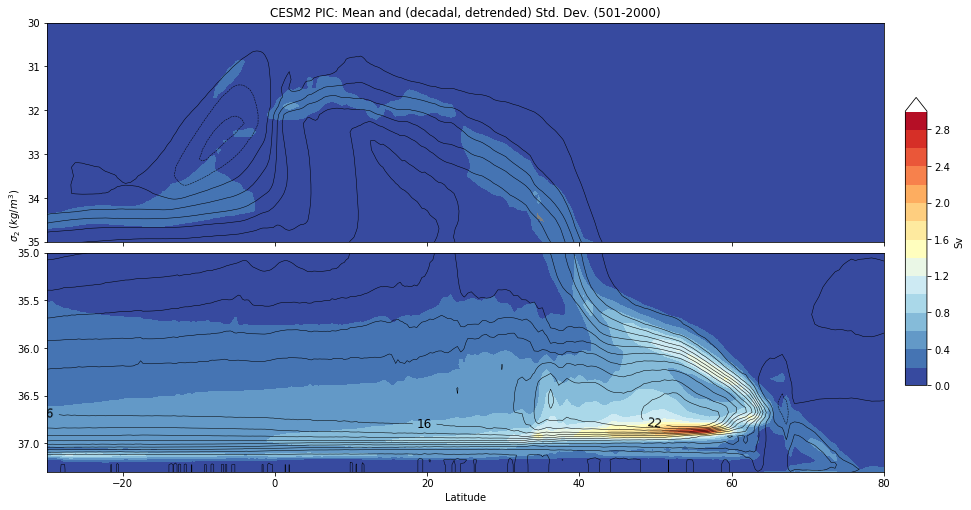

In [24]:
# Plot makes use of:   1) axis divider, 2) subplot mosaic

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(2,1,2)
ax2 = fig.add_subplot(2,1,1)

mnlevs = np.arange(0,31,1)*2. - 30
sdlevs = np.array(range(0,16,1))*0.2
xlim=[-30,80]
ylim1=[35.,30.]
ylim2 =[37.3,35.]
#mycmap = copy.copy(plt.cm.get_cmap("PuOr_r"))
mycmap = copy.copy(plt.cm.RdYlBu_r)
overclr = 'white'


# Plot 1
mean = dspic_mean.MOCsig
lpdtstd = dspic_lpdtstd.MOCsig
#mean = mean.where(lpdtstd>0.01)
#lpdtstd = lpdtstd.where(lpdtstd>0.01)
mocs =  dspic_mean.moc_s

#ax1_divider = make_axes_locatable(ax1)
#axA1 = ax1_divider.append_axes("top", size="100%", pad=0.1)
cntrA1 = ax1.contour(dspic_mean.lat_aux_grid, mocs, mean.isel(transport_reg=1),levels=mnlevs, linewidths=0.5, colors='k')
cntrA2 = ax1.contourf(dspic_mean.lat_aux_grid, mocs, lpdtstd.isel(transport_reg=1), levels=sdlevs, extend='max', cmap=mycmap)
cntrA2.cmap.set_over(overclr); cntrA2.changed()
ax1.set_ylim(ylim2)
ax1.set_xlim(xlim)
ax1.set_xlabel('Latitude')
ax1.set_facecolor('grey')
fmt = '%2.0i'
clabs = ((-30,36.7),(20,36.7),(50,36.7))
ax1.clabel(cntrA1, inline=True, fontsize=12, colors='k',fmt=fmt, manual=clabs)

axA1 = ax2
axA1.set_title('CESM2 PIC: Mean and (decadal, detrended) Std. Dev. (501-2000)')
cntrA3 = axA1.contour(dspic_mean.lat_aux_grid, mocs, mean.isel(transport_reg=1),levels=mnlevs, linewidths=0.5, colors='k')
cntrA4 = axA1.contourf(dspic_mean.lat_aux_grid, mocs, lpdtstd.isel(transport_reg=1), levels=sdlevs, extend='max', cmap=mycmap)
#cntrA4.cmap.set_over(overclr)
axA1.set_ylim(ylim1)
axA1.set_xlim(xlim)
axA1.set_xticklabels([])
axA1.set_ylabel(r'$\sigma_2\; (kg/m^{3})$',loc='bottom')
axA1.set_facecolor('grey')
fmt = '%2.0i'
clabs = ((20,35.5),(40,35.5))
axA1.clabel(cntrA4, inline=True, fontsize=12, colors='k',fmt=fmt, manual=clabs)


fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntrA4, cax=cbar_ax, label='Sv', orientation='vertical')

#fig.set_constrained_layout(True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.05)

plt.savefig('PIcontrol_0201-2000_MOC_mean_sd.pdf')

### Decadal Micro differences from 30-member Macro:

CPU times: user 21 s, sys: 842 ms, total: 21.8 s
Wall time: 54.6 s


<timed exec>:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


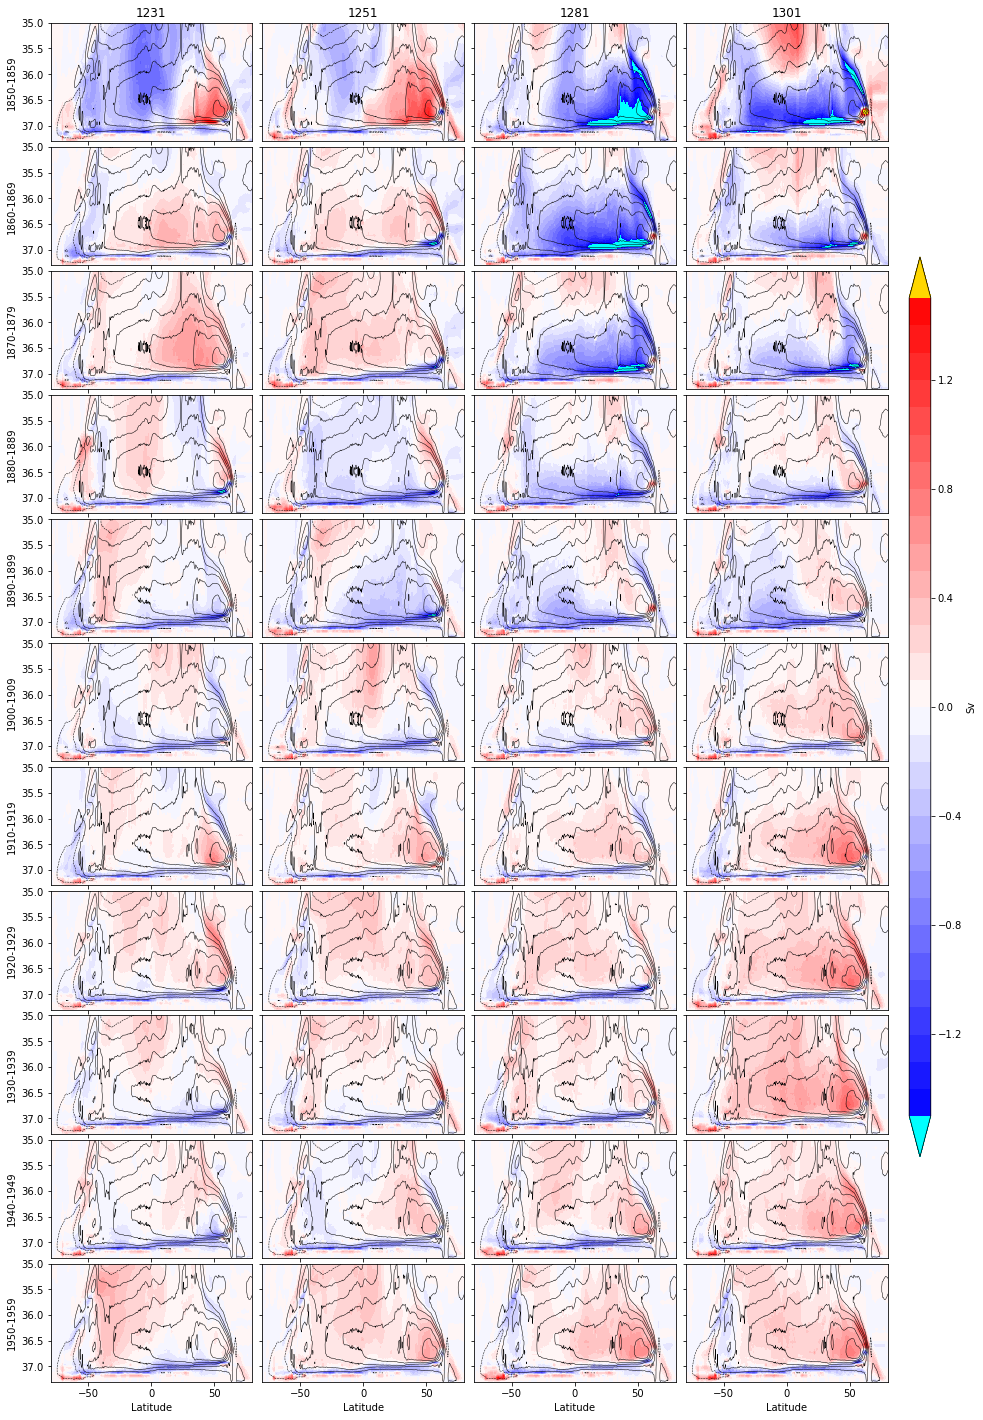

In [67]:
%%time
time0 = np.arange(1850,1960,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-80,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsmacro.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

As above but for AMOC:

CPU times: user 20.8 s, sys: 779 ms, total: 21.6 s
Wall time: 54.2 s


<timed exec>:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


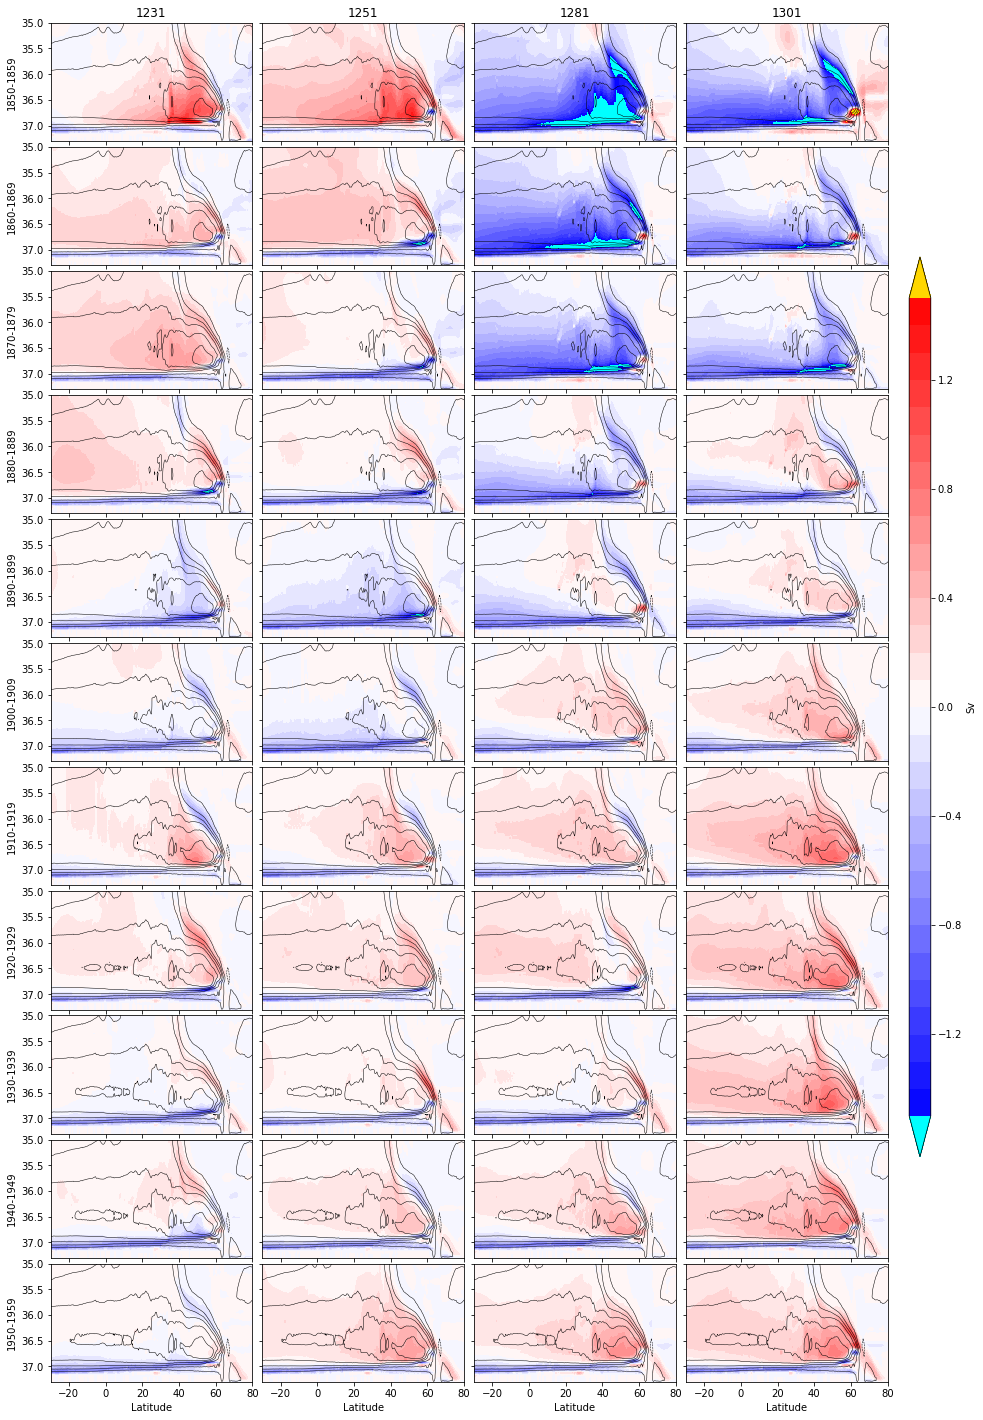

In [68]:
%%time
time0 = np.arange(1850,1960,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-30,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsmacro.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

### Decadal Micro differences from Macro1:

CPU times: user 18.5 s, sys: 652 ms, total: 19.1 s
Wall time: 45.7 s


<timed exec>:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


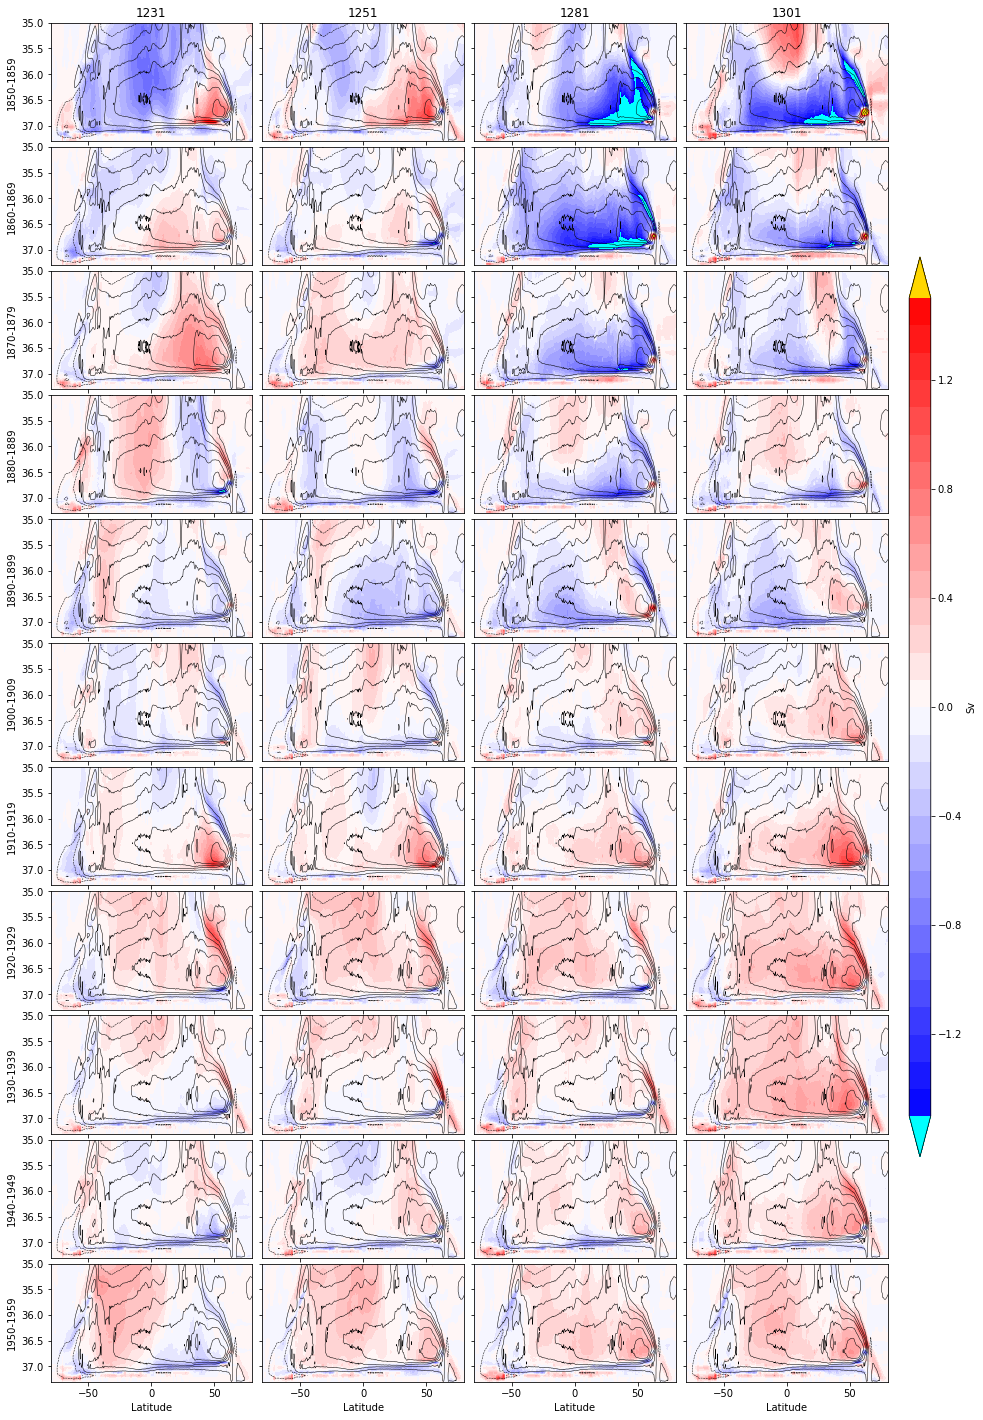

In [69]:
%%time
time0 = np.arange(1850,1960,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-80,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsmacro1.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

As above but for AMOC:

CPU times: user 18.6 s, sys: 620 ms, total: 19.3 s
Wall time: 45.8 s


<timed exec>:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


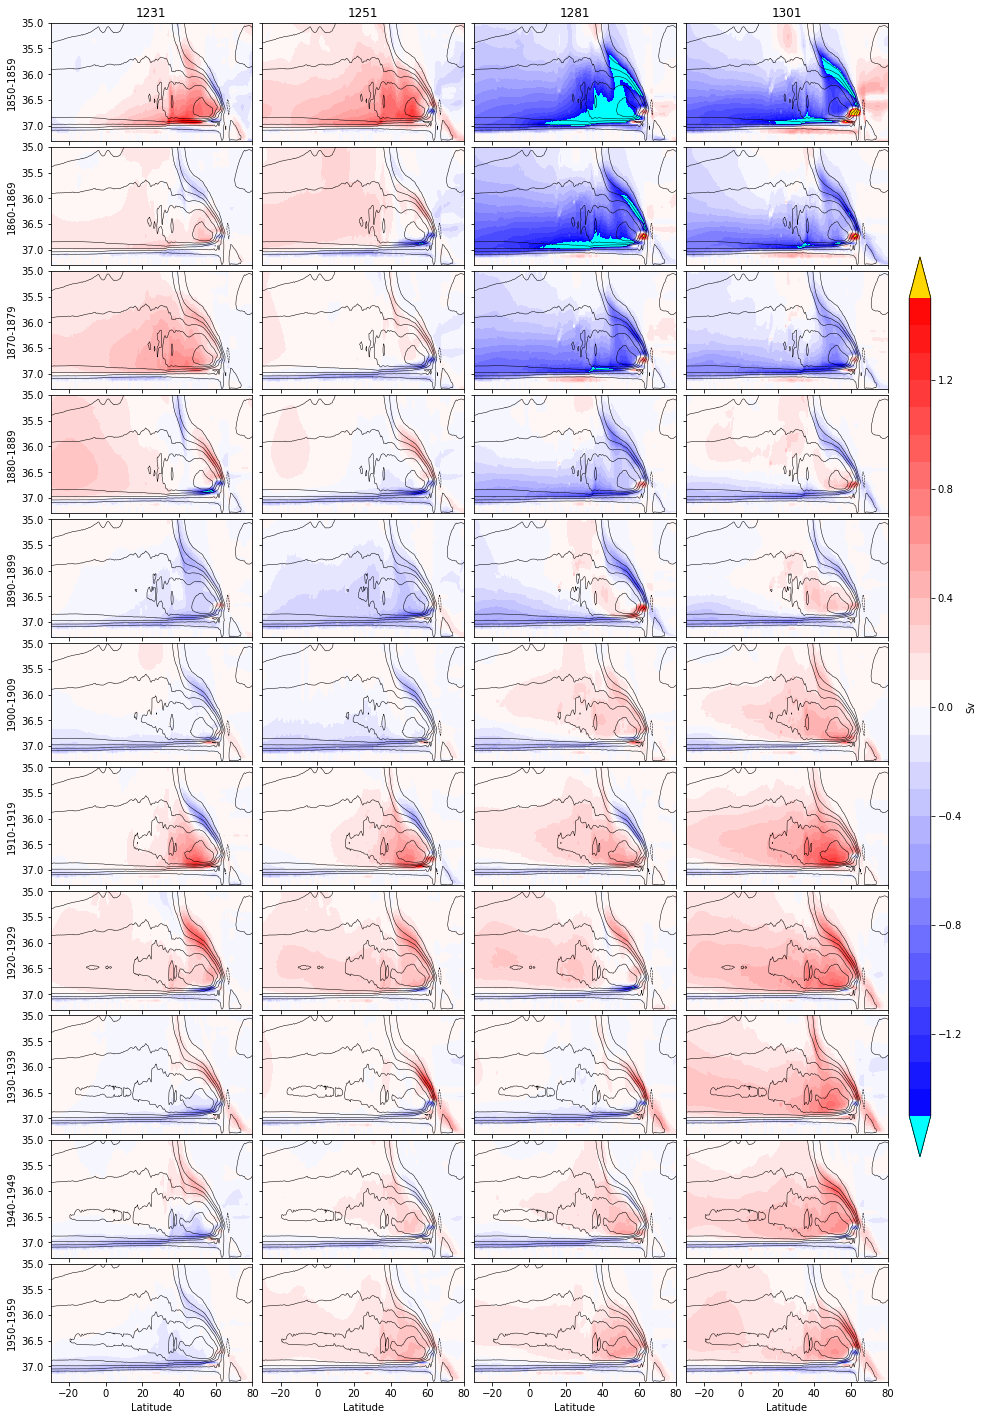

In [70]:
%%time
time0 = np.arange(1850,1960,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-30,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsmacro1.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

### Decadal Micro differences from 100-member Grand Ensemble:

CPU times: user 1min 20s, sys: 3.08 s, total: 1min 23s
Wall time: 3min 26s


<timed exec>:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


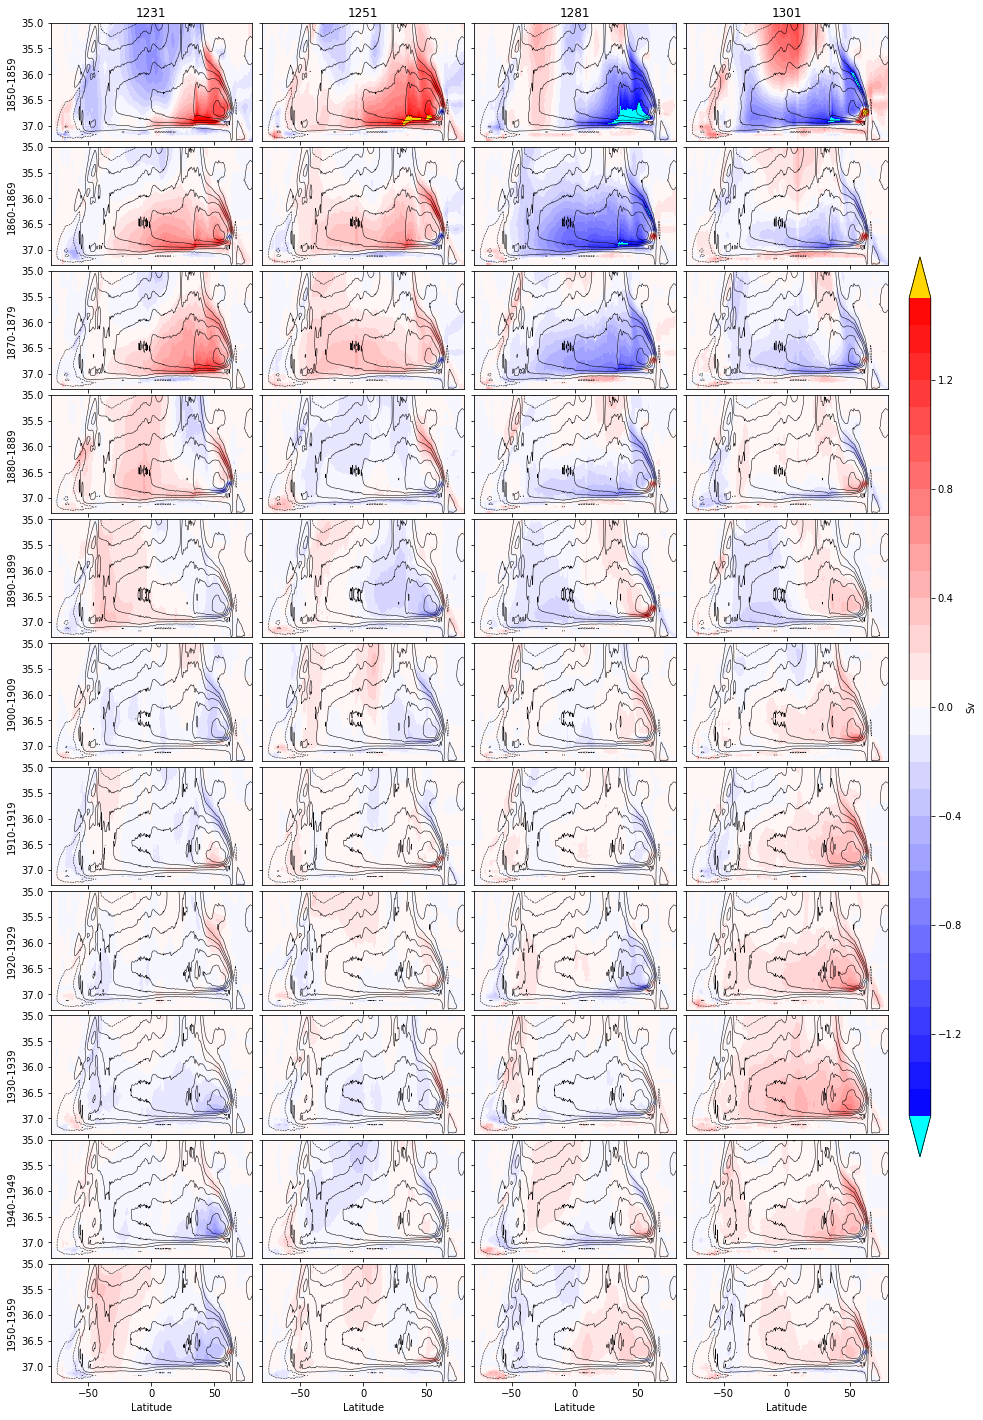

In [71]:
%%time
time0 = np.arange(1850,1960,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-80,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsall.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

As above but for AMOC:

CPU times: user 1min 22s, sys: 3.06 s, total: 1min 25s
Wall time: 3min 30s


<timed exec>:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


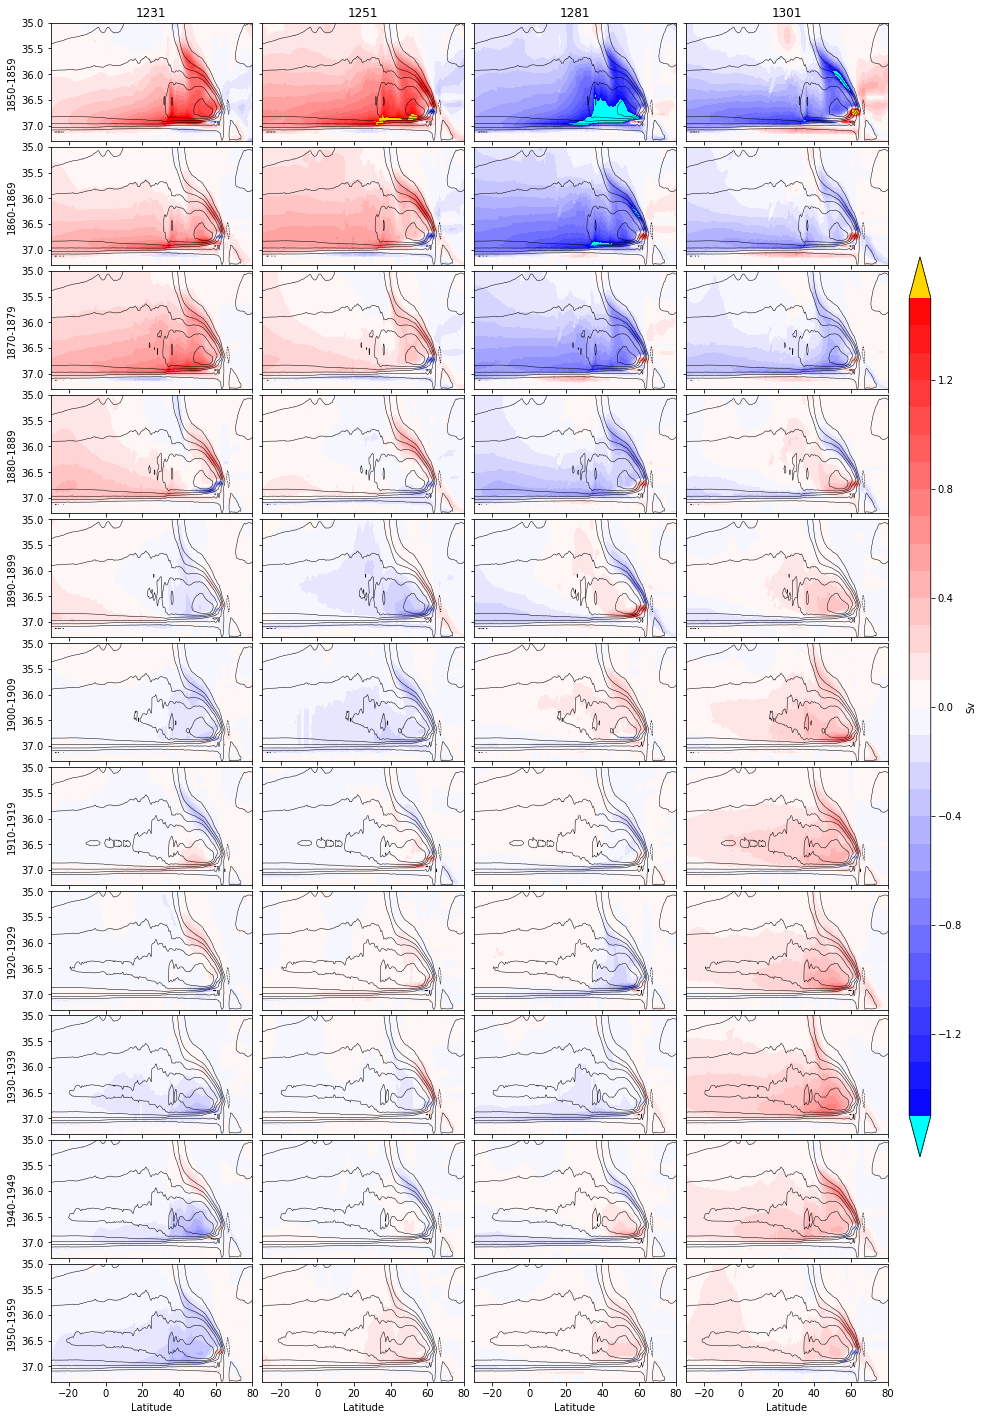

In [72]:
%%time
time0 = np.arange(1850,1960,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-30,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = dsall.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    #macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

### Decadal Prognostic Potential Predictability:
  - Following Pohlmann et al. (2004, J. Clim, 17, 4463-4472), measures ratio of ensemble variance relative to temporal variance from CESM2 pre-industrial control simulation:<br>
  $PPP(t) = 1 - \frac{\sigma_{ens}^2(t)}{\sigma_{pic}^2}$
  - Use std dev of detrended, 10-year-boxcar filtered MOC from PI-control (years 501-2000)

In [73]:
pic_lpf_sd = dspic_annanom_dt.MOCsig.rolling(time=10,center=True).mean().std('time')
pic_lpf_sd = pic_lpf_sd.where(pic_lpf_sd > 0.001)

CPU times: user 22.7 s, sys: 989 ms, total: 23.7 s
Wall time: 1min 4s


<timed exec>:87: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


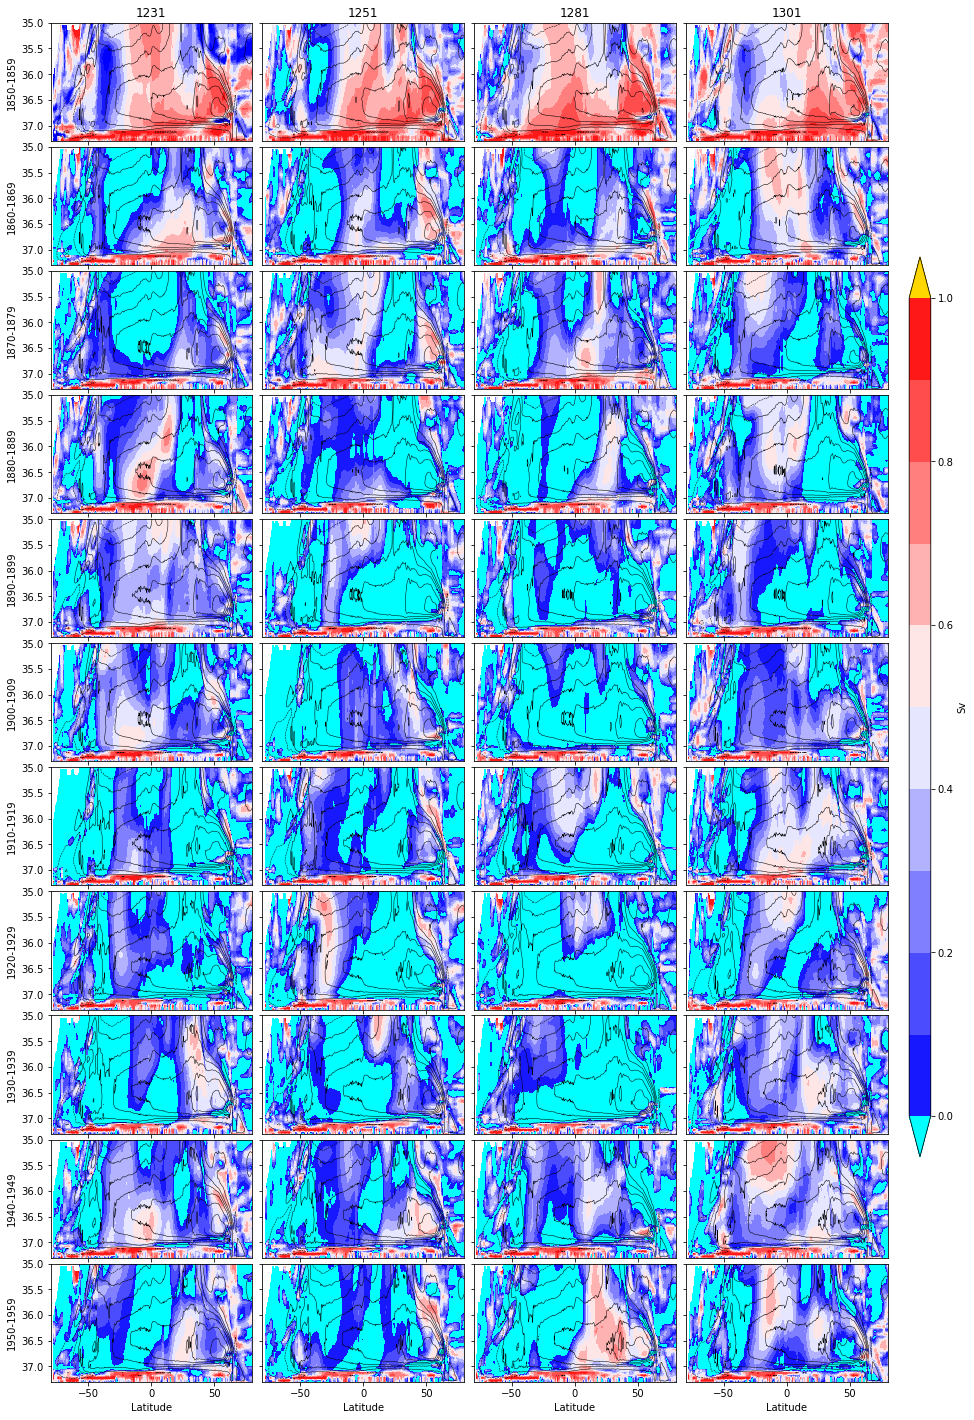

In [74]:
%%time
time0 = np.arange(1850,1960,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,11,1)*0.1
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-80,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('M') 
    std_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').std('M')
    std_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').std('M')
    std_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').std('M')
    std_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').std('M')
    ppp_1231 = 1 - ((std_1231**2)/(pic_lpf_sd.isel(transport_reg=0)**2))
    ppp_1251 = 1 - ((std_1251**2)/(pic_lpf_sd.isel(transport_reg=0)**2))
    ppp_1281 = 1 - ((std_1281**2)/(pic_lpf_sd.isel(transport_reg=0)**2))
    ppp_1301 = 1 - ((std_1301**2)/(pic_lpf_sd.isel(transport_reg=0)**2))
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(mean_1231.lat_aux_grid, mean_1231.moc_s, mean_1231,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(ppp_1231.lat_aux_grid, ppp_1231.moc_s, ppp_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(mean_1251.lat_aux_grid, mean_1251.moc_s, mean_1251,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(ppp_1251.lat_aux_grid, ppp_1251.moc_s, ppp_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(mean_1281.lat_aux_grid, mean_1281.moc_s, mean_1281,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(ppp_1281.lat_aux_grid, ppp_1281.moc_s, ppp_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(mean_1301.lat_aux_grid, mean_1301.moc_s, mean_1301,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(ppp_1301.lat_aux_grid, ppp_1301.moc_s, ppp_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

As above but for AMOC:

CPU times: user 18.8 s, sys: 806 ms, total: 19.7 s
Wall time: 53.7 s


<timed exec>:87: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


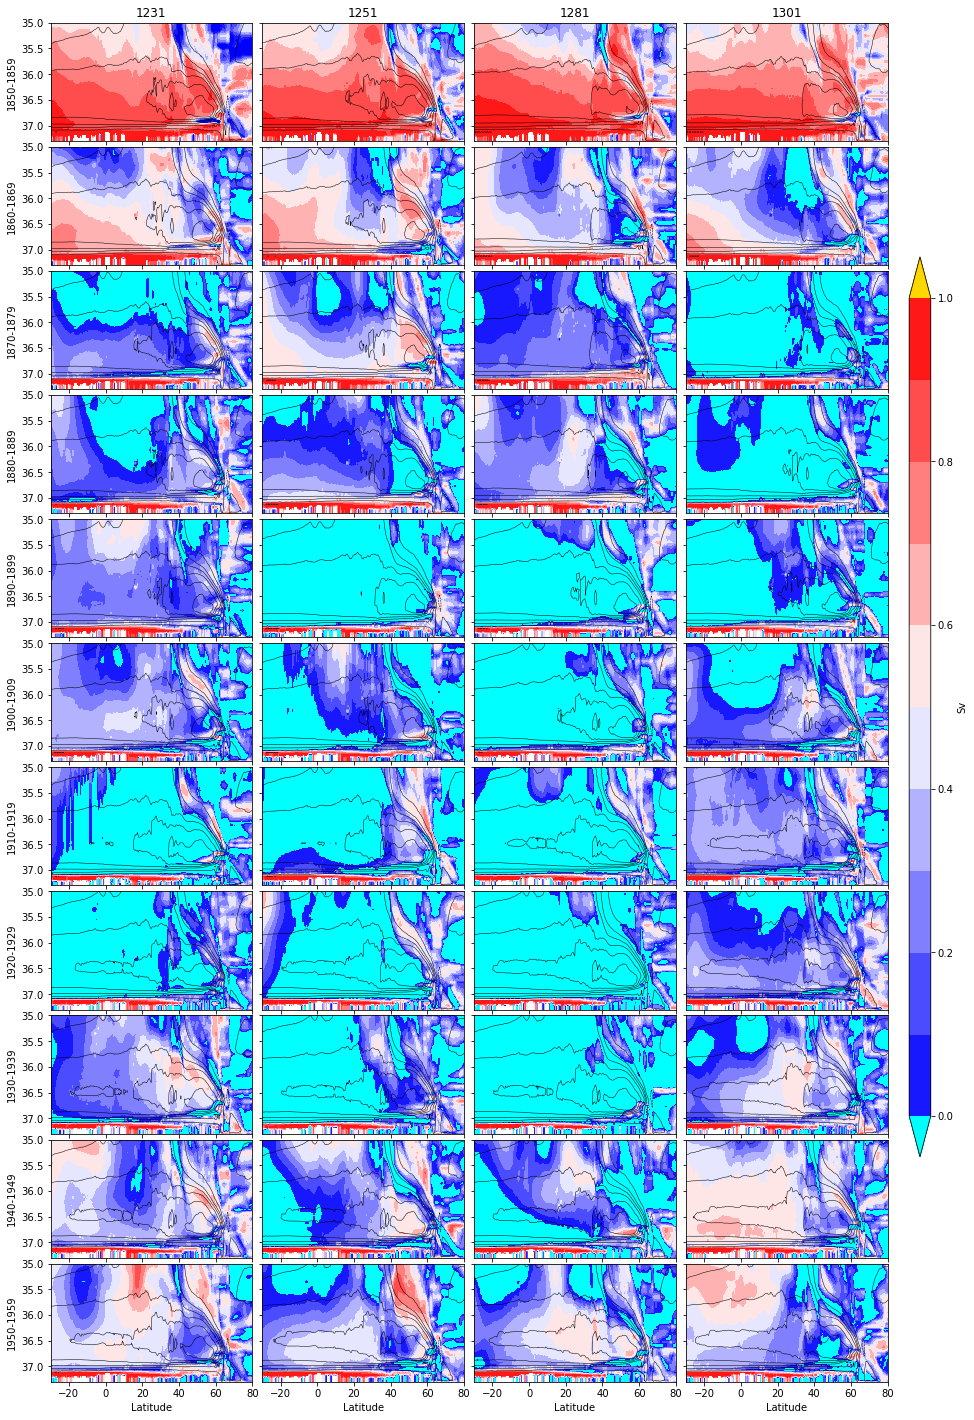

In [75]:
%%time
time0 = np.arange(1850,1960,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,11,1)*0.1
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-30,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    mean_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M')
    mean_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').mean('M') 
    std_1231 = ds1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').std('M')
    std_1251 = ds1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').std('M')
    std_1281 = ds1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').std('M')
    std_1301 = ds1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=1).mean('time').std('M')
    ppp_1231 = 1 - ((std_1231**2)/(pic_lpf_sd.isel(transport_reg=1)**2))
    ppp_1251 = 1 - ((std_1251**2)/(pic_lpf_sd.isel(transport_reg=1)**2))
    ppp_1281 = 1 - ((std_1281**2)/(pic_lpf_sd.isel(transport_reg=1)**2))
    ppp_1301 = 1 - ((std_1301**2)/(pic_lpf_sd.isel(transport_reg=1)**2))
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(mean_1231.lat_aux_grid, mean_1231.moc_s, mean_1231,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(ppp_1231.lat_aux_grid, ppp_1231.moc_s, ppp_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(mean_1251.lat_aux_grid, mean_1251.moc_s, mean_1251,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(ppp_1251.lat_aux_grid, ppp_1251.moc_s, ppp_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(mean_1281.lat_aux_grid, mean_1281.moc_s, mean_1281,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(ppp_1281.lat_aux_grid, ppp_1281.moc_s, ppp_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(mean_1301.lat_aux_grid, mean_1301.moc_s, mean_1301,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(ppp_1301.lat_aux_grid, ppp_1301.moc_s, ppp_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')